# CNN Based Models
Convolutional Neural Network are great at spotting visual features.
In the case of speech recognition, one good visual representation of audio data is the spectrogram, which shows the magnitude of the audio signal for each time frame and for each frequency.
One of the most popular ways of extracting meaningful features  from audio data is to apply a Mel Filterbank and then to apply Discrete Cosine Transform to the found features, and obtaining so the Mel Frequency Cepstral Coefficients (for speech, generally only the first 13 features are kept, which are the most important for detecting words). This is a great way to represent and to compress audio features. 

## Tasks definitions:
Each model is trained on three different tasks:
 - 10 core KWS + unknown + silence; 
 - 20 core + (unknown+silence); 
 - 35core + silence;

In [1]:
import tensorflow as tf
import os
import pathlib
import pickle
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

from models import cnn_trad_fpool3, cnn_one_fstride4
from IPython import display
from utils import *

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform


from input_pipeline import _DATA_DIR_, _BINARIES_DIR_, _UNKNOWN_CLASS_, _SILENCE_CLASS_, _MODELS_DIR_, _TASKS_
from input_pipeline import *
from metrics import *
from custom_layers import *
sns.set_context("notebook")

# Set seed for experiment reproducibility
# seed = 42
# tf.random.set_seed(seed)
# np.random.seed(seed)


2021-08-21 03:02:34.066672: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# _SMOKE_SIZE_ = 2000
_SMOKE_SIZE_ = -1

In [3]:
_TASKS_

['10kws+U+S', '20kws+U', '35kws']

## Import Data - Task 10kws+U+S

In [4]:
current_task = _TASKS_[1]

In [5]:
print(current_task)

20kws+U


In [6]:
core_kws, aux_kws, output_classes = get_kws(_DATA_DIR_, current_task)
print("Core keywords: ", core_kws)
print()
print("Auxiliary keywords: ", aux_kws)
print()
print("Output Classes: ", output_classes)
# if the binaries for the splits are not yet generated, generate them; otherwise just load them.
if len(os.listdir(_BINARIES_DIR_/current_task)) == 0:
    #Get train, validation and test data from the splits provided in the data directory
    X_train, y_train, X_valid, y_valid, X_test, y_test = get_original_splits(current_task)
else:
    X_train, y_train, X_valid, y_valid, X_test, y_test = load_original_splits(current_task)

# X_train, y_train, X_valid, y_valid, X_test, y_test = get_smoke_sized(X_train, 
#                                                                      y_train, 
#                                                                      X_valid, 
#                                                                      y_valid, 
#                                                                      X_test, 
#                                                                      y_test, 
#                                                                      smoke_size=_SMOKE_SIZE_)

print(f"Samples in Training Set: {len(X_train)}")
print(f"Samples in Test Set: {len(X_test)}")
print(f"Samples in Validation Set: {len(X_valid)}")

Core keywords:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

Auxiliary keywords:  ['tree', 'happy', 'bed', 'bird', 'dog', 'marvin', 'learn', 'forward', 'backward', 'follow', 'visual', 'wow', 'cat', 'sheila', 'house']

Output Classes:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'filler']
Samples in Training Set: 94824
Samples in Test Set: 9981
Samples in Validation Set: 11005


In [8]:
batch_size = 128
train_dataset, train_steps, valid_dataset, valid_steps, test_dataset = get_tf_datasets(X_train, 
                             y_train, 
                             X_valid, 
                             y_valid, 
                             X_test, 
                             y_test, 
                             batch_size=batch_size)

Train steps: 741
Validations steps: 86
Example of dataset element:
(<tf.Tensor: shape=(128, 16000), dtype=float32, numpy=
array([[-0.00466775,  0.0016752 , -0.00060421, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08806254, -0.00145154,  0.0011389 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.00445842,
         0.00244303, -0.00020586],
       ...,
       [-0.00225811,  0.0027997 , -0.0013    , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00633277, -0.00133353,  0.00592576, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.01172599,
         0.01813663, -0.02594898]], dtype=float32)>, <tf.Tensor: shape=(128,), dtype=int64, numpy=
array([ 9, 13, 18, 16, 20, 20, 20,  6, 20,  5,  3,  5, 18, 13, 15, 20, 13,
        8,  1,  7, 18, 18, 20, 19,  9,  6,  0, 20, 20, 20, 20, 20,  2, 16,
       19, 18,  8,  2,  2,  0,  2, 19, 13, 10, 11, 2

2021-08-21 03:02:55.183420: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


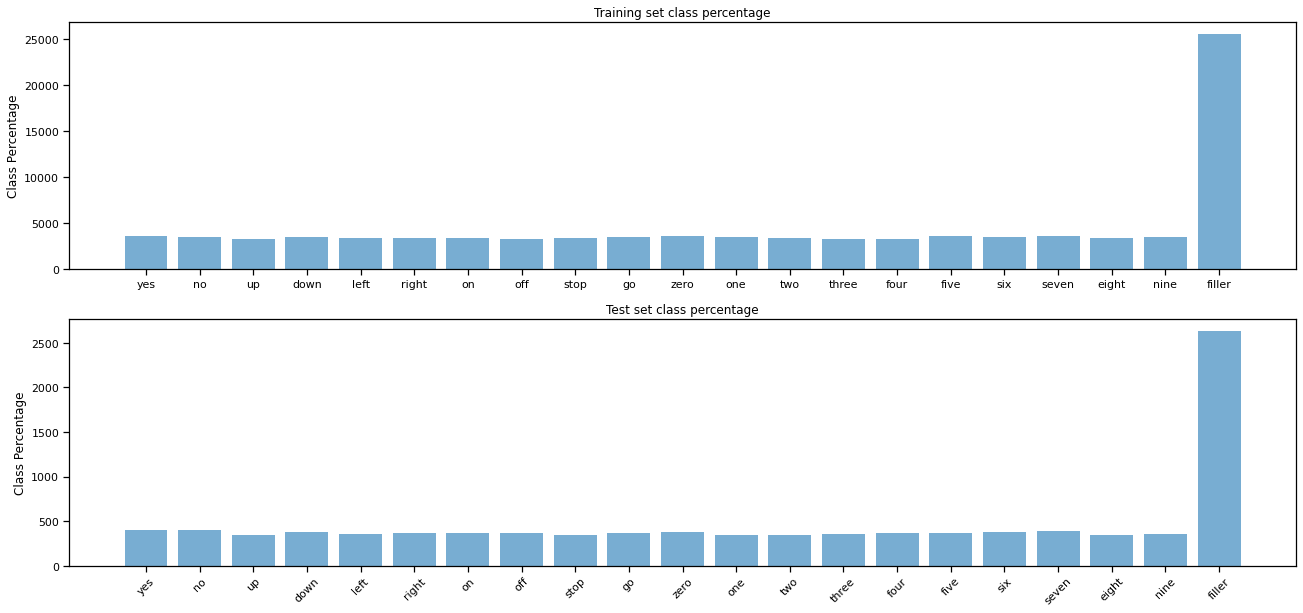

In [9]:
visualize_class_balance(y_train, y_test, output_classes)

# Baseline Models
`cnn-trad-fpool3`, `cnn-one-fstride4` from https://static.googleusercontent.com/media/research.google.com/it//pubs/archive/43969.pdf

## Model 1 (cnn-trad-fpool3)

input dimensions are: (time_dimension, frequency_dimension)

- CONV2D Layer: n_filters=64, filter_size = (20, 8), stride = (1,1);
- MaxPool2D: pool_dimension = (1, 3);
- CONV2D Layer: n_filters=64, filter_size = (10, 4), stride = (1,1);
- Dense Layer with linear activation and 32 units;
- Dense layer with ReLu activation and  128 units;
- Output Layer with n_outputs units and softmax activation.



In [11]:
n_mfcc=40
# n_filters=[20,30,40,50]
n_filters = 40
mfcc_deltas=False
win_size = 400
hop_size=160
model_name = "cnn_trad_fpool3"

model_cnn_trad_fpool3 = cnn_trad_fpool3(train_dataset,
                                        output_classes,
                                        n_mfcc=n_mfcc,
                                        mfcc_deltas=mfcc_deltas,
                                       model_name = model_name,
                                       n_filters=n_filters,
                                        win_size=win_size,
                                        hop_size=hop_size)
model_cnn_trad_fpool3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model_cnn_trad_fpool3.summary()

Input shape: (16000,)


2021-08-21 03:03:43.059747: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Model: "cnn_trad_fpool3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16000)]           0         
_________________________________________________________________
mfcc (MFCC)                  (None, 98, 40, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 40, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 79, 33, 64)        10304     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 11, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 70, 8, 64)         163904    
_________________________________________________________________
flatten (Flatten)            (None, 35840)         

In [12]:
# ## Learning Rate Scheduler: decides how to make the learning rate decrease with time
# # Example: start with lr=0,001 and decrease by a factor of 0.4 every 10 epochs
# def scheduler(epoch, lr):
#     return 0.4*(epoch%10) * lr
    
# tf.keras.callbacks.LearningRateScheduler(
#     schedule, verbose=0
# )

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
history = model_cnn_trad_fpool3.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/30


2021-08-21 03:03:44.952779: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-08-21 03:03:45.040518: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-21 03:03:45.289817: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-08-21 03:03:45.291147: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-21 03:03:45.564355: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100


127/741 [====>.........................] - ETA: 37s - loss: 12.6173 - accuracy: 0.2627

KeyboardInterrupt: 

In [12]:
#save model
#cnn_trad_fpool3
model_cnn_trad_fpool3.save(_MODELS_DIR_/current_task/(model_cnn_trad_fpool3.name+'.h5'))

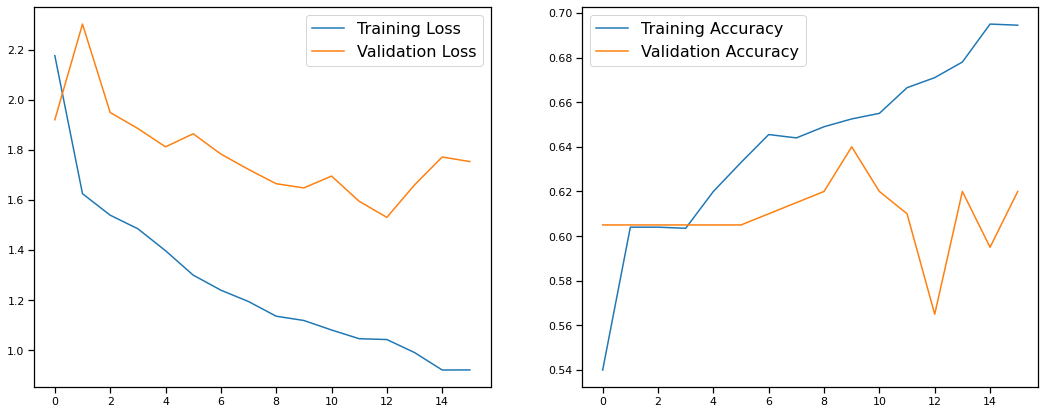

In [13]:
training_data = history.history
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(range(len(training_data['loss'])), training_data['loss'], label="Training Loss")
plt.plot(range(len(training_data['val_loss'])), training_data['val_loss'], label="Validation Loss")
plt.legend(fontsize=16)

plt.subplot(1,2,2)
plt.plot(range(len(training_data['accuracy'])), training_data['accuracy'], label="Training Accuracy")
plt.plot(range(len(training_data['val_accuracy'])), training_data['val_accuracy'], label="Validation Accuracy")

plt.legend(fontsize=16)
plt.show()

In [19]:
def nice_conf_matrix(model, test_dataset, test_steps, y_test, current_task, form=".3f"):
    y_scores = model.predict(test_dataset, steps=test_steps)[:len(y_test)]
    y_pred = np.array(np.argmax(y_scores, axis=1))
    y_true = np.array(y_test)
    # compute test accuracy
    test_acc = sum(y_pred == y_true) / len(y_true)
    print(f'Test set accuracy: {test_acc:.3%}')

    confusion_mtx = confusion_matrix(y_true, y_pred, normalize='true') 
    plt.figure(figsize=(13, 10))
    sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
                annot=True, fmt =form)
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.title(f"Model: {model.name}; Task: {current_task}; Accuracy: {test_acc}%", fontsize=15)
    plt.savefig(_MODELS_DIR_/current_task/f'{model.name}.png', dpi=300)
    plt.show()

Test set accuracy: 54.000%


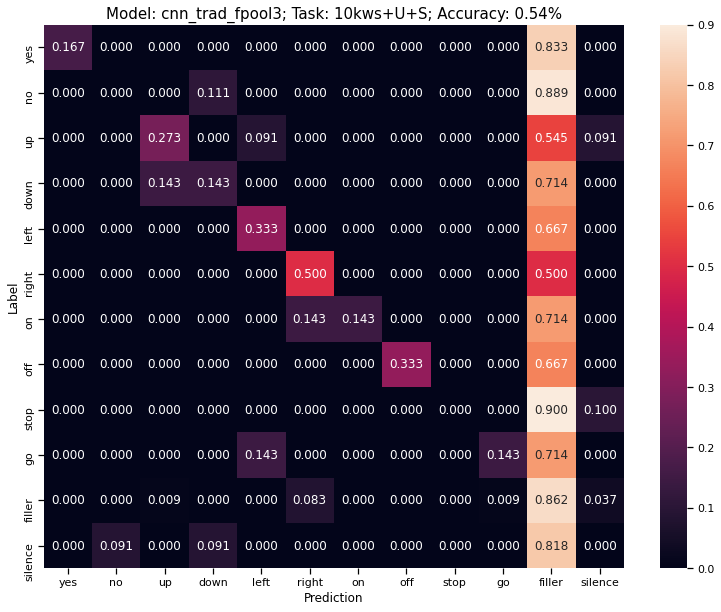

In [62]:
nice_conf_matrix(model_cnn_trad_fpool3, test_dataset, test_steps, y_test, current_task)

In [63]:
fpr, fnr, roc_auc = get_fpr_fnr_aucs(y_test, y_scores, output_classes)

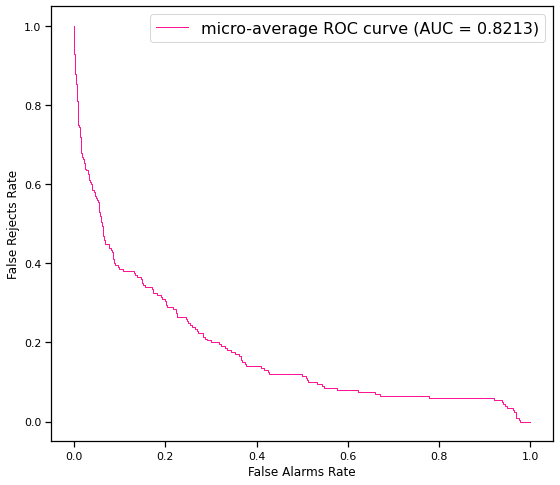

In [64]:
plt.figure(figsize=(9,8))
plt.plot(fpr["micro"], fnr["micro"],
         color='deeppink', linestyle='-', linewidth=1, label='micro-average ROC curve (AUC = {0:0.4f})'
               ''.format(roc_auc["micro"]))
plt.xlabel("False Alarms Rate")
plt.ylabel("False Rejects Rate")
plt.legend(fontsize=16)
plt.show()

## Model 2 (cnn-one-fstride4)

input dimensions are: (time_dimension, frequency_dimension)

- CONV2D Layer: n_filters=186, filter_size = (32, 8), stride = (1,4);
- Dense Layer with linear activation and 32 units;
- Dense layer with ReLu activation and  128 units;
- Dense layer with ReLu activation and  128 units;
- Output Layer with n_outputs units and softmax activation.


In [55]:
model_cnn_one_fstride4 = cnn_one_fstride4(train_dataset,
                                        output_classes,
                                        n_mfcc=n_mfcc,
                                        mfcc_deltas=mfcc_deltas,
                                       model_name = "cnn_one_fstride4",
                                       n_filters=n_filters,
                                        win_size=win_size,
                                        hop_size=hop_size)

model_cnn_one_fstride4.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model_cnn_one_fstride4.summary()

Input shape: (16000,)
Model: "cnn_one_fstride4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16000)]           0         
_________________________________________________________________
mfcc_1 (MFCC)                (None, 98, 40, 1)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 98, 40, 1)         4         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 67, 9, 186)        47802     
_________________________________________________________________
flatten_1 (Flatten)          (None, 112158)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                3589088   
_________________________________________________________________
dense_4 (Dense)             

In [56]:
early_stopping = tf.keras.callbacks.EarlyStopping(
            verbose=1, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
history = model_cnn_one_fstride4.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/30
16/16 [==============================] - 2s 68ms/step - loss: 1.8321 - accuracy: 0.5160 - val_loss: 2.3459 - val_accuracy: 0.6050
Epoch 2/30
16/16 [==============================] - 1s 41ms/step - loss: 1.5251 - accuracy: 0.6145 - val_loss: 2.0905 - val_accuracy: 0.6000
Epoch 3/30
16/16 [==============================] - 1s 40ms/step - loss: 1.3287 - accuracy: 0.6360 - val_loss: 1.8177 - val_accuracy: 0.5950
Epoch 4/30
16/16 [==============================] - 1s 39ms/step - loss: 1.1945 - accuracy: 0.6405 - val_loss: 1.8750 - val_accuracy: 0.5850
Epoch 5/30
16/16 [==============================] - 1s 46ms/step - loss: 1.0584 - accuracy: 0.6700 - val_loss: 1.8216 - val_accuracy: 0.6100
Epoch 6/30
16/16 [==============================] - 1s 46ms/step - loss: 1.0387 - accuracy: 0.6715 - val_loss: 1.8836 - val_accuracy: 0.5550
Epoch 00006: early stopping


In [58]:
#save model
model_cnn_one_fstride4.save(_MODELS_DIR_/current_task/(model_cnn_one_fstride4.name+'.h5'))

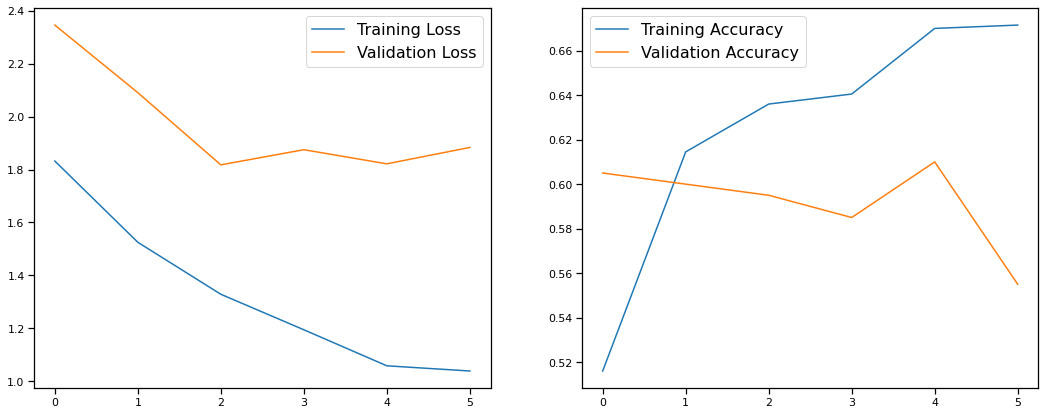

In [59]:
training_data = history.history
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(range(len(training_data['loss'])), training_data['loss'], label="Training Loss")
plt.plot(range(len(training_data['val_loss'])), training_data['val_loss'], label="Validation Loss")
plt.legend(fontsize=16)

plt.subplot(1,2,2)
plt.plot(range(len(training_data['accuracy'])), training_data['accuracy'], label="Training Accuracy")
plt.plot(range(len(training_data['val_accuracy'])), training_data['val_accuracy'], label="Validation Accuracy")

plt.legend(fontsize=16)
plt.show()

Test set accuracy: 58.000%


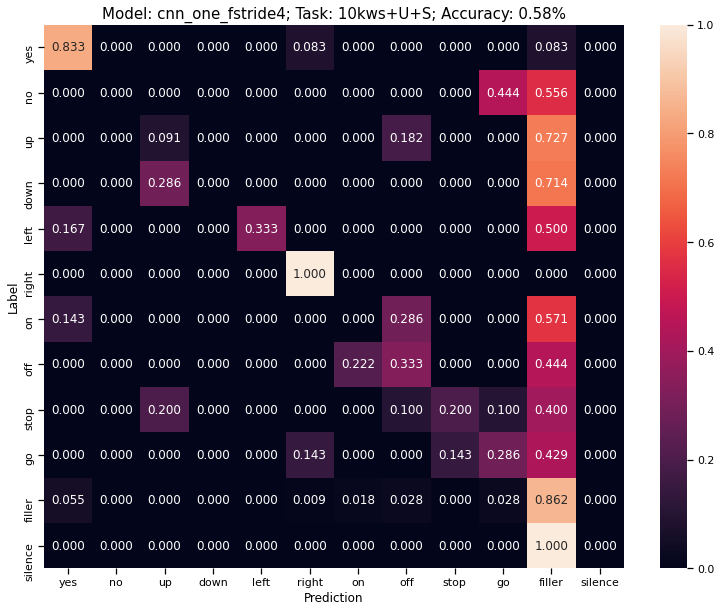

In [65]:
nice_conf_matrix(model_cnn_one_fstride4, test_dataset, test_steps, y_test, current_task)

## Residual CNN Network Models

In [30]:
def kws_res_net(ds):
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)
    
    X_input0 = tf.keras.Input(input_shape)
    #X = MelSpectrogram(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=40)(X_input)
    X_input = MFCC(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=40, n_cepstral=40)(X_input0)
    X = layers.BatchNormalization(axis=-1)(X_input)
    # Define the input as a tensor with shape input_shape (1 line)
    # Zero-padding 1x1 (1 line)
#     X = layers.ZeroPadding2D((1, 1))(X_input)
    
    # Stage 1 (4 lines)
    X = layers.Conv2D(64, (20,8), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis =-1, name = 'bn_conv1')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((1, 3))(X)

    # Stage 2 (3 lines)
    X = convolutional_block(X, f = 3, filters = [64, 64, 64], stage = 2, block='a', s = 2)
    X = identity_block(X, 3, [64, 64, 64], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 64], stage=2, block='c')

#     # Stage 3 (4 lines)
#     X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
#     X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
#     X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
#     X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

#     # Stage 4 (6 lines)
#     X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
#     X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (3 lines)
#     X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
#     X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
#     X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (1 line). Use "X = AveragePooling2D(...)(X)"
    X = tf.keras.layers.AveragePooling2D(name='avg_pool')(X)

    # Output layer
    X = layers.Flatten()(X)
    X = layers.Dense(len(output_classes), name='fc', kernel_initializer = glorot_uniform(seed=0))(X)
    
    ### END CODE HERE ###
    
    # Create model
    model = tf.keras.Model(inputs = X_input0, outputs = X, name='ResNetKWS')

    return model

In [31]:
model_res_net = kws_res_net(train_dataset)

model_res_net.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model_res_net.summary()

Input shape: (16000,)
Model: "ResNetKWS"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 16000)]      0                                            
__________________________________________________________________________________________________
mfcc_4 (MFCC)                   (None, 98, 120, 1)   0           input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 98, 120, 1)   4           mfcc_4[0][0]                     
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 79, 113, 64)  10304       batch_normalization_4[0][0]      
____________________________________________________________________

In [32]:
#Train the model
EPOCHS = 50
early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
history = model_res_net.fit(
    train_dataset, 
    validation_data=valid_dataset,  
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/50
 28/741 [>.............................] - ETA: 2:24 - loss: nan - accuracy: 0.0326

KeyboardInterrupt: 

In [69]:
#save model
model_res_net.save(_MODELS_DIR_/current_task/(model_res_net.name+'.h5'))

/home/rmazzier/Desktop/HDA/tf_venv/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


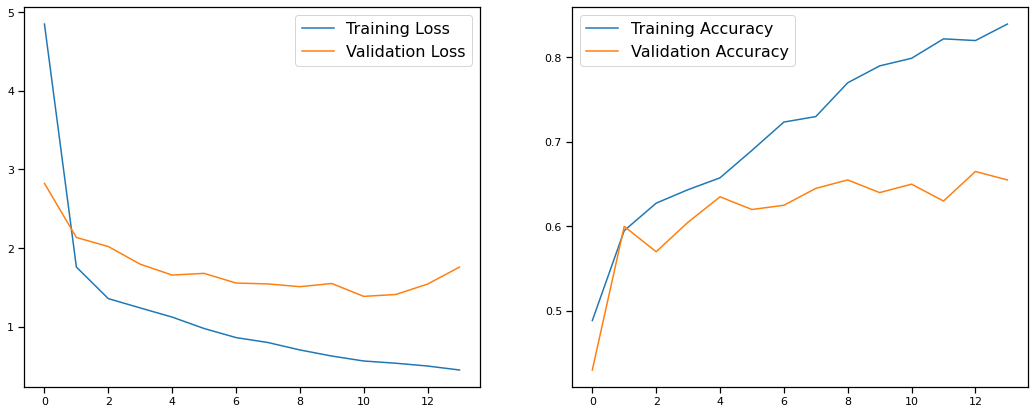

In [73]:
training_data = history.history
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(range(len(training_data['loss'])), training_data['loss'], label="Training Loss")
plt.plot(range(len(training_data['val_loss'])), training_data['val_loss'], label="Validation Loss")
plt.legend(fontsize=16)

plt.subplot(1,2,2)
plt.plot(range(len(training_data['accuracy'])), training_data['accuracy'], label="Training Accuracy")
plt.plot(range(len(training_data['val_accuracy'])), training_data['val_accuracy'], label="Validation Accuracy")

plt.legend(fontsize=16)
plt.show()

Test set accuracy: 64.500%


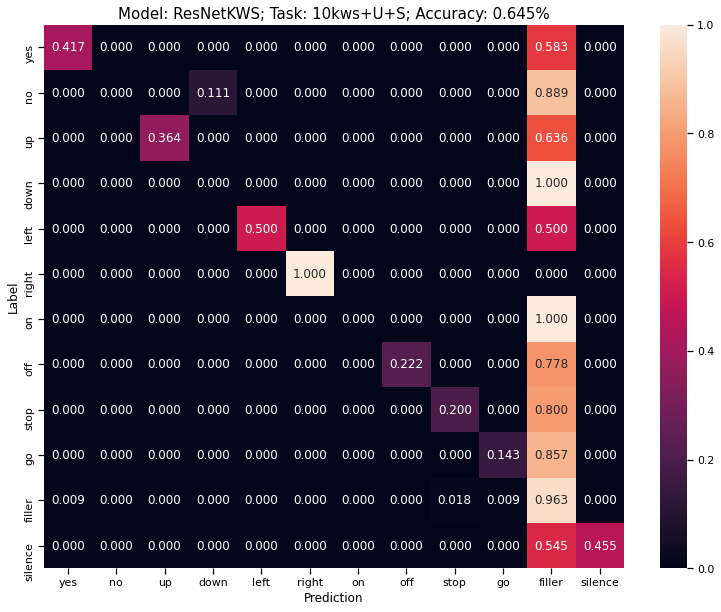

In [74]:
nice_conf_matrix(model_res_net, test_dataset, test_steps, y_test, current_task)

## Import data: 35keywords task

In [9]:
current_task = '35kws'
_SMOKE_SIZE_ = 2000

In [10]:
core_kws, aux_kws, output_classes = get_kws(_DATA_DIR_, current_task)
print("Core keywords: ", core_kws)
print()
print("Auxiliary keywords: ", aux_kws)
print()
print("Output Classes: ", output_classes)
# if the binaries for the splits are not yet generated, generate them; otherwise just load them.
if len(os.listdir(_BINARIES_DIR_/current_task)) == 0:
    #Get train, validation and test data from the splits provided in the data directory
    X_train, y_train, X_valid, y_valid, X_test, y_test = get_original_splits(current_task)
else:
    X_train, y_train, X_valid, y_valid, X_test, y_test = load_original_splits(current_task)

X_train, y_train, X_valid, y_valid, X_test, y_test = get_smoke_sized(X_train, 
                                                                     y_train, 
                                                                     X_valid, 
                                                                     y_valid, 
                                                                     X_test, 
                                                                     y_test, 
                                                                     smoke_size=_SMOKE_SIZE_)

print(f"Samples in Training Set: {len(X_train)}")
print(f"Samples in Test Set: {len(X_test)}")
print(f"Samples in Validation Set: {len(X_valid)}")

Core keywords:  ['off' 'three' 'happy' 'eight' 'up' 'no' 'seven' 'marvin' 'five' 'cat'
 'visual' 'forward' 'right' 'wow' 'zero' 'learn' 'bird' 'left' 'nine'
 'house' 'dog' 'backward' 'on' 'two' 'sheila' 'follow' 'tree' 'yes' 'four'
 'one' 'stop' 'six' 'down' 'go' 'bed']

Auxiliary keywords:  []

Output Classes:  ['off' 'three' 'happy' 'eight' 'up' 'no' 'seven' 'marvin' 'five' 'cat'
 'visual' 'forward' 'right' 'wow' 'zero' 'learn' 'bird' 'left' 'nine'
 'house' 'dog' 'backward' 'on' 'two' 'sheila' 'follow' 'tree' 'yes' 'four'
 'one' 'stop' 'six' 'down' 'go' 'bed']
Samples in Training Set: 2000
Samples in Test Set: 200
Samples in Validation Set: 200


In [11]:
batch_size = 64
train_dataset, train_steps, valid_dataset, valid_steps, test_dataset, test_steps = get_tf_datasets(X_train, 
                             y_train, 
                             X_valid, 
                             y_valid, 
                             X_test, 
                             y_test, 
                             batch_size=batch_size)

Train steps: 32
Validations steps: 4
Test steps: 4
Example of dataset element:
(<tf.Tensor: shape=(64, 16000), dtype=float32, numpy=
array([[ 2.18555611e-02,  9.99018550e-04, -1.14238821e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.38320790e-03, -2.47316994e-03, -6.69192523e-04],
       [-6.61726594e-02,  2.43558735e-02,  8.62770155e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.25175857e-03,  1.32023403e-03,  5.37192868e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.90959720e-02,  1.64099038e-04,  1.77427139e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.19251374e-04, -2.82285357e-04,  2.78732623e-05]], dtype=float32)>, <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([23, 32,  5, 26, 29, 25, 30,  8, 22, 22, 3

In [12]:
y_test

array([ 2, 31, 14, 20,  5, 32, 19, 22, 22, 20, 33, 22,  0, 15,  3,  6, 33,
       25,  2,  6, 14, 28, 17, 18,  8, 27,  8,  6, 23,  5,  9, 32,  3, 23,
        1, 30, 23, 12, 14, 29, 31, 17, 33, 17, 24, 33, 30, 18, 20, 30, 27,
        0,  9, 32, 10, 22,  7, 23, 16,  3, 17, 22, 30,  2,  4, 18, 22,  3,
       13,  8, 31, 27,  9,  2, 20, 31, 15,  8,  9,  8, 14, 32, 29, 11,  2,
       32, 21, 32, 33, 27, 31, 29, 27, 34, 17, 12, 32, 29,  6,  6,  0, 12,
        1, 30, 29, 23, 26, 10,  7, 31,  1, 32,  8,  4, 27,  9, 20, 34, 12,
        9, 21,  6, 19, 14, 28, 16, 33, 10, 31,  8,  0, 32, 29, 27,  6, 24,
       27,  2,  1, 14, 17, 30, 33,  3, 14, 13,  0,  5,  5, 19, 19, 20, 22,
       14, 18,  5, 28,  4, 22, 31,  3,  3, 26,  3,  0,  8, 13, 29,  4, 18,
       26,  1, 24, 10,  2, 10,  4,  9, 32, 22, 30,  2, 17, 30,  7, 30,  2,
        8, 14,  4, 34,  0,  8, 20, 14, 16, 27, 26,  5, 24])

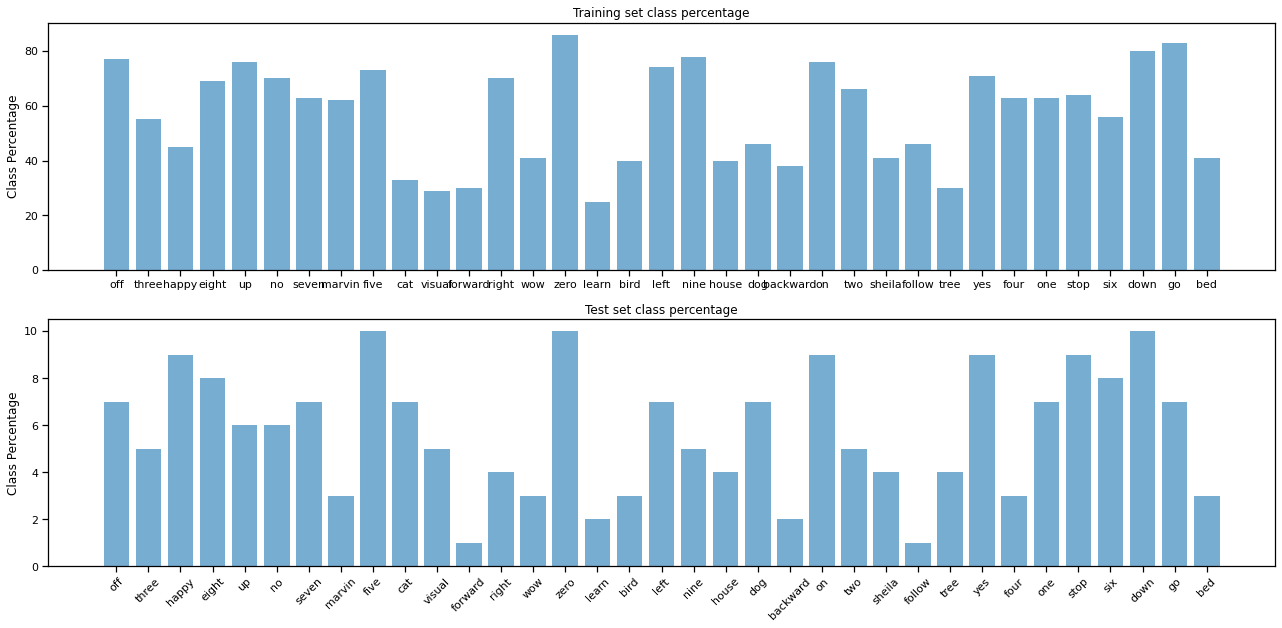

In [13]:
visualize_class_balance(y_train, y_test, output_classes)

## cnn_trad_fpool3

In [14]:
n_mfcc=40
# n_filters=[20,30,40,50]
n_filters = 40
mfcc_deltas=False
win_size = 400
hop_size=160
model_name = "cnn_trad_fpool3"

model_cnn_trad_fpool3 = cnn_trad_fpool3(train_dataset,
                                        output_classes,
                                        n_mfcc=n_mfcc,
                                        mfcc_deltas=mfcc_deltas,
                                       model_name = model_name,
                                       n_filters=n_filters,
                                        win_size=win_size,
                                        hop_size=hop_size)
model_cnn_trad_fpool3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Input shape: (16000,)


In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
history = model_cnn_trad_fpool3.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/30


2021-08-19 20:58:23.409636: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-08-19 20:58:23.508340: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-19 20:58:23.755698: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-08-19 20:58:23.756877: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-19 20:58:24.033157: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100


32/32 [==============================] - 4s 51ms/step - loss: 13.3861 - accuracy: 0.0300 - val_loss: 3.5087 - val_accuracy: 0.0550
Epoch 2/30
32/32 [==============================] - 1s 37ms/step - loss: 3.5157 - accuracy: 0.0425 - val_loss: 3.5186 - val_accuracy: 0.0350
Epoch 3/30
32/32 [==============================] - 1s 34ms/step - loss: 3.5130 - accuracy: 0.0430 - val_loss: 3.5203 - val_accuracy: 0.0350
Epoch 4/30
32/32 [==============================] - 1s 36ms/step - loss: 3.5118 - accuracy: 0.0430 - val_loss: 3.5209 - val_accuracy: 0.0350
Epoch 00004: early stopping


In [16]:
#save model
#cnn_trad_fpool3
model_cnn_trad_fpool3.save(_MODELS_DIR_/current_task/(model_cnn_trad_fpool3.name+'.h5'))

## trad_one_fstride4

In [23]:
n_mfcc=40
# n_filters=[20,30,40,50]
n_filters = 40
mfcc_deltas=False
win_size = 400
hop_size=160
model_name = "cnn_one_fstride4"

model_cnn_one_fstride4 = cnn_one_fstride4(train_dataset,
                                        output_classes,
                                        n_mfcc=n_mfcc,
                                        mfcc_deltas=mfcc_deltas,
                                       model_name = model_name,
                                       n_filters=n_filters,
                                        win_size=win_size,
                                        hop_size=hop_size)
model_cnn_one_fstride4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Input shape: (16000,)


In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
model_cnn_one_fstride4.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/30
32/32 [==============================] - 2s 43ms/step - loss: 38.0759 - accuracy: 0.0340 - val_loss: 3.6395 - val_accuracy: 0.0550
Epoch 2/30
32/32 [==============================] - 1s 21ms/step - loss: 3.5552 - accuracy: 0.0335 - val_loss: 3.5462 - val_accuracy: 0.0650
Epoch 3/30
32/32 [==============================] - 1s 21ms/step - loss: 3.5408 - accuracy: 0.0360 - val_loss: 3.5364 - val_accuracy: 0.0650
Epoch 4/30
32/32 [==============================] - 1s 21ms/step - loss: 3.5306 - accuracy: 0.0355 - val_loss: 3.5312 - val_accuracy: 0.0650
Epoch 5/30
32/32 [==============================] - 1s 22ms/step - loss: 3.5234 - accuracy: 0.0315 - val_loss: 3.5279 - val_accuracy: 0.0300
Epoch 00005: early stopping


In [25]:
#cnn_one_fst
model_cnn_one_fstride4.save(_MODELS_DIR_/current_task/(model_cnn_one_fstride4.name+'.h5'))

# ResNet

In [25]:
model_res_net = kws_res_net(train_dataset)

model_res_net.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# model_res_net.summary()

Input shape: (16000,)
(None, 40, 19, 64)
(None, 40, 19, 64)
(None, 40, 19, 64)
(None, 40, 19, 64)


In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
history = model_res_net.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/30
1482/1482 [==============================] - 199s 132ms/step - loss: 1.4543 - accuracy: 0.6149 - val_loss: 1.1775 - val_accuracy: 0.6590
Epoch 2/30
1482/1482 [==============================] - 192s 129ms/step - loss: 0.6514 - accuracy: 0.8100 - val_loss: 0.7519 - val_accuracy: 0.7821
Epoch 3/30
1482/1482 [==============================] - 192s 129ms/step - loss: 0.5221 - accuracy: 0.8471 - val_loss: 0.6572 - val_accuracy: 0.8164
Epoch 4/30
1482/1482 [==============================] - 198s 134ms/step - loss: 0.4551 - accuracy: 0.8653 - val_loss: 0.6492 - val_accuracy: 0.8104
Epoch 5/30
1482/1482 [==============================] - 197s 133ms/step - loss: 0.4057 - accuracy: 0.8802 - val_loss: 0.5619 - val_accuracy: 0.8362
Epoch 6/30
1482/1482 [==============================] - 192s 129ms/step - loss: 0.3674 - accuracy: 0.8891 - val_loss: 0.5498 - val_accuracy: 0.8413
Epoch 7/30
1482/1482 [==============================] - 192s 129ms/step - loss: 0.3385 - accuracy: 0.8986 - val_

In [29]:
# ResNet1
model_res_net.save(_MODELS_DIR_/current_task/(model_res_net.name+'.h5'))

#cnn_trad_fpool3
model_cnn_trad_fpool3.save(_MODELS_DIR_/current_task/(model_cnn_trad_fpool3.name+'.h5'))

## Third Task

In [26]:
_SMOKE_SIZE_ = 2000

['10kws+U+S', '20kws+U', '35kws']

Core keywords:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

Auxiliary keywords:  ['follow', 'happy', 'dog', 'sheila', 'bed', 'cat', 'visual', 'forward', 'learn', 'wow', 'bird', 'tree', 'backward', 'marvin', 'house']

Output Classes:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'filler']
Samples in Training Set: 2000
Samples in Test Set: 200
Samples in Validation Set: 200
Train steps: 32
Validations steps: 4
Test steps: 4
Example of dataset element:
(<tf.Tensor: shape=(64, 16000), dtype=float32, numpy=
array([[-0.00648298,  0.00051864,  0.00099384, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.06386882,  0.00310891, -0.02246521, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.00244187,
         0.

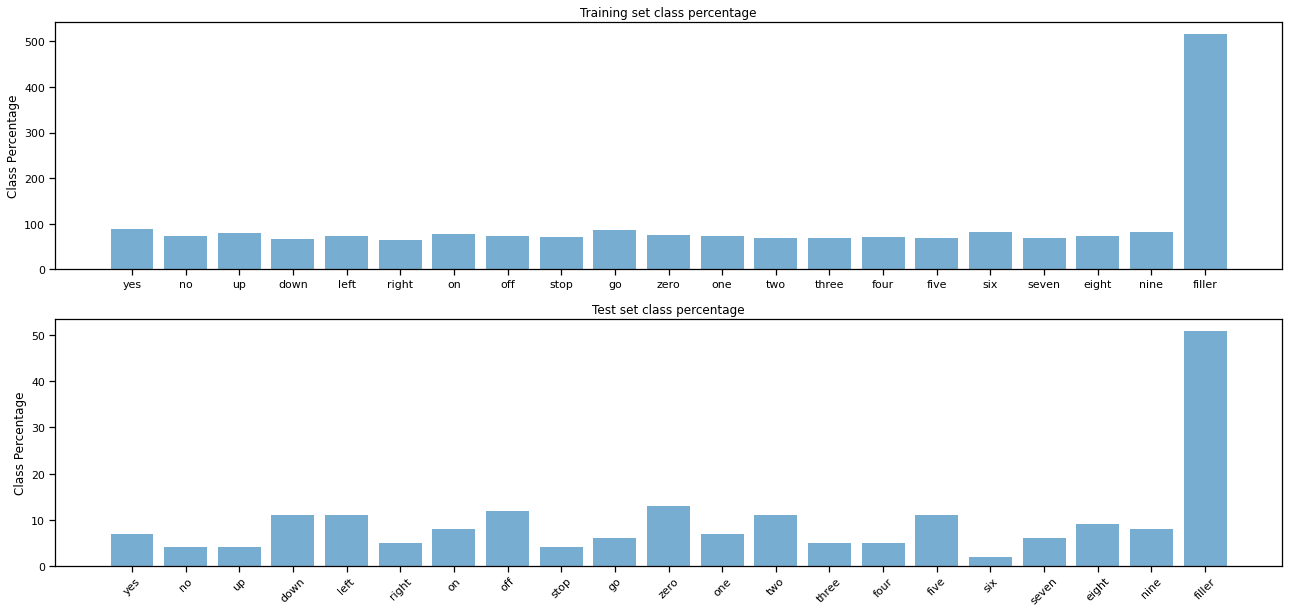

Input shape: (16000,)
Epoch 1/30
32/32 [==============================] - 2s 45ms/step - loss: 13.9685 - accuracy: 0.2275 - val_loss: 2.8327 - val_accuracy: 0.2500
Epoch 2/30
32/32 [==============================] - 1s 33ms/step - loss: 2.8056 - accuracy: 0.2580 - val_loss: 2.8053 - val_accuracy: 0.2500
Epoch 3/30
32/32 [==============================] - 1s 33ms/step - loss: 2.8008 - accuracy: 0.2580 - val_loss: 2.8061 - val_accuracy: 0.2500
Epoch 4/30
32/32 [==============================] - 1s 34ms/step - loss: 2.8000 - accuracy: 0.2580 - val_loss: 2.8059 - val_accuracy: 0.2500
Epoch 00004: early stopping
Input shape: (16000,)
Epoch 1/30
32/32 [==============================] - 2s 33ms/step - loss: 59.4009 - accuracy: 0.1045 - val_loss: 4.6001 - val_accuracy: 0.0450
Epoch 2/30
32/32 [==============================] - 1s 22ms/step - loss: 3.1054 - accuracy: 0.0965 - val_loss: 2.9761 - val_accuracy: 0.2050
Epoch 3/30
32/32 [==============================] - 1s 21ms/step - loss: 2.8930 

/home/rmazzier/Desktop/HDA/tf_venv/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [29]:
current_task = '20kws+U'


core_kws, aux_kws, output_classes = get_kws(_DATA_DIR_, current_task)
print("Core keywords: ", core_kws)
print()
print("Auxiliary keywords: ", aux_kws)
print()
print("Output Classes: ", output_classes)
# if the binaries for the splits are not yet generated, generate them; otherwise just load them.
if len(os.listdir(_BINARIES_DIR_/current_task)) == 0:
    #Get train, validation and test data from the splits provided in the data directory
    X_train, y_train, X_valid, y_valid, X_test, y_test = get_original_splits(current_task)
else:
    X_train, y_train, X_valid, y_valid, X_test, y_test = load_original_splits(current_task)

X_train, y_train, X_valid, y_valid, X_test, y_test = get_smoke_sized(X_train, 
                                                                     y_train, 
                                                                     X_valid, 
                                                                     y_valid, 
                                                                     X_test, 
                                                                     y_test, 
                                                                     smoke_size=_SMOKE_SIZE_)

print(f"Samples in Training Set: {len(X_train)}")
print(f"Samples in Test Set: {len(X_test)}")
print(f"Samples in Validation Set: {len(X_valid)}")

batch_size = 64
train_dataset, train_steps, valid_dataset, valid_steps, test_dataset, test_steps = get_tf_datasets(X_train, 
                             y_train, 
                             X_valid, 
                             y_valid, 
                             X_test, 
                             y_test, 
                             batch_size=batch_size)

y_test

visualize_class_balance(y_train, y_test, output_classes)

## cnn_trad_fpool3

n_mfcc=40
# n_filters=[20,30,40,50]
n_filters = 40
mfcc_deltas=False
win_size = 400
hop_size=160
model_name = "cnn_trad_fpool3"

model_cnn_trad_fpool3 = cnn_trad_fpool3(train_dataset,
                                        output_classes,
                                        n_mfcc=n_mfcc,
                                        mfcc_deltas=mfcc_deltas,
                                       model_name = model_name,
                                       n_filters=n_filters,
                                        win_size=win_size,
                                        hop_size=hop_size)
model_cnn_trad_fpool3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
history = model_cnn_trad_fpool3.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

#save model
#cnn_trad_fpool3
model_cnn_trad_fpool3.save(_MODELS_DIR_/current_task/(model_cnn_trad_fpool3.name+'.h5'))

## trad_one_fstride4

n_mfcc=40
# n_filters=[20,30,40,50]
n_filters = 40
mfcc_deltas=False
win_size = 400
hop_size=160
model_name = "cnn_one_fstride4"

model_cnn_one_fstride4 = cnn_one_fstride4(train_dataset,
                                        output_classes,
                                        n_mfcc=n_mfcc,
                                        mfcc_deltas=mfcc_deltas,
                                       model_name = model_name,
                                       n_filters=n_filters,
                                        win_size=win_size,
                                        hop_size=hop_size)
model_cnn_one_fstride4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
model_cnn_one_fstride4.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

#cnn_one_fst
model_cnn_one_fstride4.save(_MODELS_DIR_/current_task/(model_cnn_one_fstride4.name+'.h5'))

# ResNet

model_res_net = kws_res_net(train_dataset)

model_res_net.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# model_res_net.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
history = model_res_net.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

# ResNet1
model_res_net.save(_MODELS_DIR_/current_task/(model_res_net.name+'.h5'))

#cnn_trad_fpool3
model_cnn_trad_fpool3.save(_MODELS_DIR_/current_task/(model_cnn_trad_fpool3.name+'.h5'))